# The Dataset

We used this dataset for our miniproject: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

The dataset contains 6 classes of images: `building`, `forest`, `glacier`, `mountain`, `sea`, and `street`. We decided to delete the class `street` and it's corresponding pictures to simplify the learning process. The images are divided into folders with their respective labels. We used the `image_dataset_from_directory` method of Keras to convert the images into a TensorFlow dataset object for training.

## Importing the Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
training_img_path = "./dataset/seg_train/seg_train/"

img_size = 50
batch_size = 32
seed = 42   # the seed will make sure the two datasets are not overlapping

train_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode='int',
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode='int',
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

print(train_ds.class_names)

Found 11652 files belonging to 5 classes.
Using 9322 files for training.
Found 11652 files belonging to 5 classes.
Using 2330 files for validation.
['buildings', 'forest', 'glacier', 'mountain', 'sea']


Let's see the first few images of the training dataset. Here, we'll define a function that we'll use again later in the notebook.

To ensure the model won't eat up too many of our computer's resources, we downscaled the images from $150 \times 150px$ to $50 \times 50px$.

2023-03-06 20:20:57.812485: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-06 20:20:57.812632: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


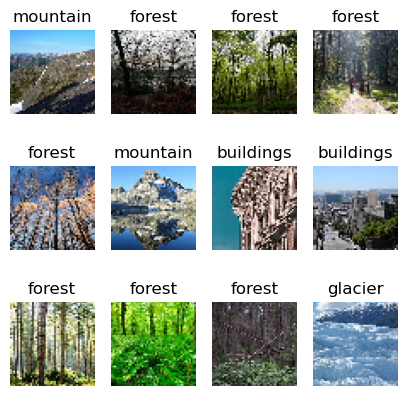

In [3]:
def show_dataset():
  plt.figure(figsize=(5, 5))
  for images, labels in train_ds.take(1):
    for i in range(12):
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(train_ds.class_names[labels[i]])
      plt.axis("off")

show_dataset()

# Underfitting Model
We will create a model that is too simple and won't describe the data accurately enough.

## Building the Model
We start with a convolutional layer that'll import/rescale the images to `img_size`, using the ReLU activation function (for all the convolution and dense layers).

Then, run a kernel of $3 \times 3$ over each image 16 times. `padding=same` is referring to the padding of the image (needed because of the kernel) being filled with zeros.

Following that is another convolution layer and max pooling layer. Next, the image will be flattened into a vector, ready to be fed to the following dense layer. In this case, we first wanted to apply dropout to the layer, but we ended up just halfing the amount of nodes of that layer. Why? We learned that the difference between applying `dropout(0.5)` and halving the nodes of the layer is that dropout randomly drops out nodes during each training iteration, which means that **different** nodes will be dropped out in each iteration. This allows the network to learn more robust and generalizable representations of the data, as it is forced to rely on a subset of nodes in each iteration, which prevents overfitting. While halving the nodes reduces the number of nodes in the layer permanently, which means that the network has less capacity to learn and represent complex patterns in the data. This then leads to underfitting, where the model is not able to capture the important features in the data. Which is exactly what we want. Also, dropout is present during training, but not during inference.

The last dense layer represents the output layer, having a shared softmax activation layer to determine the probabilities of the 5 different classes.

This task was interesting because we initially built a model that was too simple, even for underfitting. After the second epoch, it couldn't learn any more information because it simply was not complex enough. As a result, the accuracy stalled at around 0.25 and stayed the same for all the remaining epochs. We were not happy with that, so we now created a model that can actually improve with each epoch while still underfitting.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(6, (3,3), input_shape=(img_size,img_size,3), activation='relu', padding='same'),
    MaxPooling2D(),

    Conv2D(6, (3,3), activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),
    Dense(5, activation='softmax')
])
model._name='underfitting_model'

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "underfitting_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 6)         168       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 6)         330       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 864)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 4325      
Total params: 4,823
Trainable params: 4,823
Non-trainable params: 0
______________________________________________

## Training the Model

In [5]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

Epoch 1/20
292/292 [==============================] - 3s 9ms/step - loss: 4.8365 - accuracy: 0.3736 - val_loss: 1.4732 - val_accuracy: 0.4395
Epoch 2/20
292/292 [==============================] - 3s 10ms/step - loss: 1.3164 - accuracy: 0.4895 - val_loss: 1.1468 - val_accuracy: 0.5412
Epoch 3/20
292/292 [==============================] - 3s 10ms/step - loss: 1.0731 - accuracy: 0.5821 - val_loss: 1.0084 - val_accuracy: 0.6107
Epoch 4/20
292/292 [==============================] - 3s 9ms/step - loss: 0.9420 - accuracy: 0.6408 - val_loss: 0.9473 - val_accuracy: 0.6292
Epoch 5/20
292/292 [==============================] - 3s 10ms/step - loss: 0.8657 - accuracy: 0.6669 - val_loss: 0.9197 - val_accuracy: 0.6438
Epoch 6/20
292/292 [==============================] - 3s 10ms/step - loss: 0.8136 - accuracy: 0.6888 - val_loss: 0.9110 - val_accuracy: 0.6571
Epoch 7/20
292/292 [==============================] - 3s 10ms/step - loss: 0.7779 - accuracy: 0.7054 - val_loss: 0.8829 - val_accuracy: 0.6665
E

## Visualize and analyze the model
Now, we'll have a look at how well the model performs.

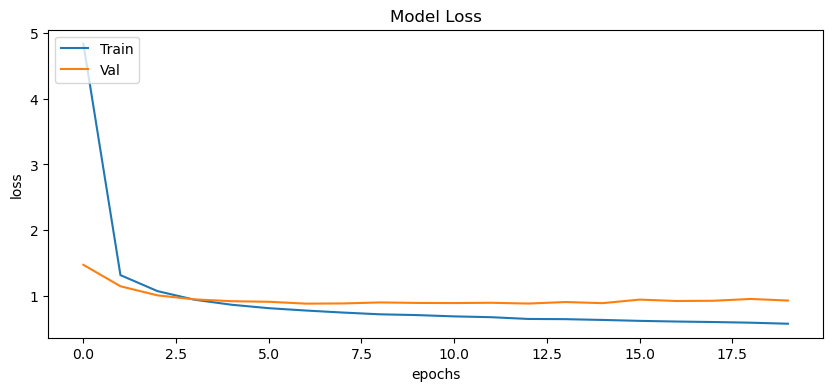

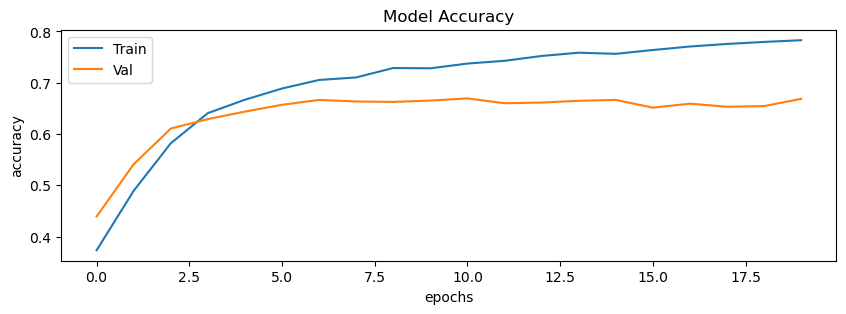

In [6]:
def visualize_loss_and_accuracy():
    # Plot the training and validation Loss
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Train','Val'], loc= 'upper left')
    plt.show()

    # Plot the model accuracy
    plt.figure(figsize=(10,3))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

visualize_loss_and_accuracy()

As we see here, in the beginning, there's a gap in between the the validation and training loss and also in the accuracy. That is because of the randomness of the two different sample sets.

We can see from the learning curves that the model slowly converges and is indeed underfitting. Both the training and validation accuracy curves plateau at a low value, indicating that the model is not learning the patterns in the data well enough.

### Make Prediction on the test dataset

In [7]:
testing_img_path = "./dataset/seg_test/seg_test/"

test_ds = keras.utils.image_dataset_from_directory(
    testing_img_path,
    labels="inferred",
    label_mode='int',
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.concatenate([y for x, y in test_ds], axis=0)

print('Predicted classes:', predicted_classes)
print('True labels:', true_classes)

Found 2499 files belonging to 5 classes.
Predicted classes: [4 2 2 ... 4 0 3]
True labels: [4 2 1 ... 2 0 4]


### Evaluate the performance of the model

In [8]:
def evaluate_model():
    accuracy = model.evaluate(test_ds)[1]
    print(f'Accuracy: {accuracy}')

evaluate_model()

79/79 [==============================] - 0s 5ms/step - loss: 0.9363 - accuracy: 0.6791
Accuracy: 0.6790716052055359


### Classification Report


In [9]:
print('Classification Report:\n', metrics.classification_report(y_true=true_classes, y_pred=predicted_classes))

#https://www.kaggle.com/code/avantikab/intel-image-classification-cnn


Classification Report:
               precision    recall  f1-score   support

           0       0.16      0.17      0.16       437
           1       0.23      0.24      0.23       474
           2       0.23      0.18      0.20       553
           3       0.21      0.25      0.23       525
           4       0.20      0.18      0.19       510

    accuracy                           0.20      2499
   macro avg       0.20      0.20      0.20      2499
weighted avg       0.20      0.20      0.20      2499



### Confusion Matrix
The confusion matrix is another way to visualize the performance of the model and wether it is underfitting or not.

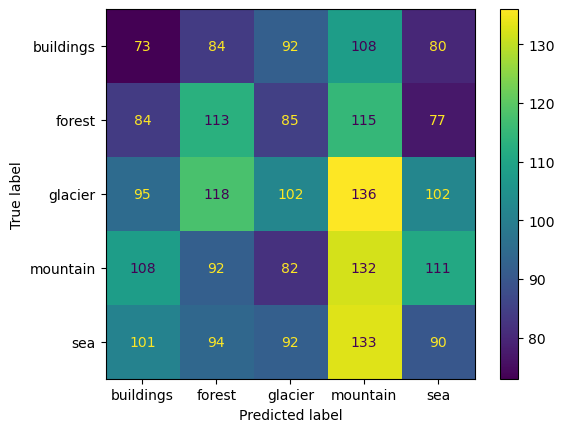

In [10]:

def print_confusion_matrix():
    confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=test_ds.class_names)
    display.plot()
    plt.show()

print_confusion_matrix()


There is no clear diagonal line in the middle, in fact, the matrix shows that the mapping of the classes is all over the place. Which again confirms that this model is indeed underfitting.